## Modules

In [1]:
%matplotlib inline
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
from imblearn.combine import SMOTEENN
from sklearn.model_selection import train_test_split

from sklearn.ensemble import VotingClassifier
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neighbors import LocalOutlierFactor
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.pipeline import Pipeline

from sklearn.preprocessing import normalize
from sklearn.decomposition import PCA
from sklearn import metrics

## Preprocessing

In [10]:
#Loading the Dataframe
Dataset_std = pd.read_pickle("../Data/Data_te_std.pkl")   #Standardized Dataset
Attack_label = pd.read_pickle("../Data/Attack_label.pkl") #Attack Labels 0:Normal, 1:Attack
Attack_type_raw = pd.read_pickle("../Data/Attack_type.pkl")   #Attack Types 
mapping_dict = {'DDoS_UDP': 1, 'DDoS_ICMP': 1, 'DDoS_HTTP': 1, 'DDoS_TCP': 1,
                'Port_Scanning': 2, 'Fingerprinting': 2, 'Vulnerability_scanner': 2,
                'MITM' : 3, 'XSS' : 4, 'SQL_injection': 4, 'Uploading':4, 
                'Backdoor': 5, 'Password': 5, 'Ransomware':5, 'Normal':6}
Attack_type = Attack_type_raw.map(mapping_dict)

# # Joining Dataset_std and Attack_type
# Dataset_std['Attack_type'] = Attack_type

# #Oversampling the minority classes
# Dataset, Target_label = SMOTEENN(random_state= 22).fit_resample(Dataset_std, Attack_label)
# Target_type = Dataset['Attack_type']
# Dataset = Dataset.drop(columns = 'Attack_type')

#Oversampling the minority classes
Dataset, Target_type = SMOTEENN(random_state= 22).fit_resample(Dataset_std, Attack_type)
Target_label = Target_type.apply(lambda x: 0 if x == 6 else 1)

#Splitting the dataset into training and testing
X_train, X_test, Y_train, Y_test = train_test_split(Dataset, Target_label, train_size=25000, test_size=120000, random_state=22) # stratify= Target_type / Target_label
_, _, Y_ref, _ = train_test_split(Dataset, Target_type, train_size=25000 ,test_size=120000, random_state=22)


In [11]:
pca = PCA(n_components=15)
X_train_PCA = pca.fit_transform(X_train)
X_test_PCA = pca.transform(X_test)

In [25]:
print(X_test.shape, Y_test.shape, (Y_test==1).sum(), (Y_test==0).sum())
X_bal_test, Y_bal_test = SMOTEENN(random_state= 22).fit_resample(X_test, Y_test)
print(X_bal_test.shape, Y_bal_test.shape, (Y_bal_test==1).sum(), (Y_bal_test==0).sum())

(120000, 36) (120000,) 103247 16753
(202633, 36) (202633,) 100809 101824


## Functions

In [26]:
#Function to get the indices of the attack type
def get_index(attack_type: int, data: np.ndarray) -> np.ndarray:
    indices = np.where(data[:] == attack_type)[0]
    return indices  

#Function to remove a attack type from the dataframe
def remove_attack_type(data_X: np.ndarray, attack_type: int) -> np.ndarray:
    indices_to_remove = get_index(attack_type, Y_ref)
    new_data = np.delete(data_X, indices_to_remove, axis=0)
    return new_data

#Function for Evaluation
def evaluate_bin(test: np.ndarray, pred: np.ndarray, display:bool = True) -> None:
    df_metric = pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test, pred)*100,                              
                              'Precision':metrics.precision_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test, pred, pos_label= 1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test, pred, pos_label= 1, average = 'binary' )*100}, 
                              index= ['Anomaly'])
    if display:
        metrics.ConfusionMatrixDisplay.from_predictions(test, pred, display_labels=['Normal', 'Abnormal']) #normalize= 'true',
    return df_metric

#Classes for pipeline
class SampleExtractor(BaseEstimator, TransformerMixin):
    def __init__(self, num_samples=1000):
        self.num_samples = num_samples
        self.is_fitting = False
    
    def fit(self, X, y=None):
        self.is_fitting = True
        return self
    
    def transform(self, X, y=None):
        if self.is_fitting:
            X_sampled = X[:self.num_samples]
            if y is not None:
                y_sampled = y[:self.num_samples]
                return X_sampled , y_sampled
            else:
                return X_sampled
        else:
            return X
        
    def fit_transform(self, X, y=None):
        return self.fit(X, y).transform(X, y)
    
# Custom pipeline to handle different behavior during fit and predict
class CustomPipeline(Pipeline):
    def fit(self, X, y=None, **fit_params):
        Xt, yt = self._fit_transform(X, y, **fit_params)
        self.steps[-1][-1].fit(Xt, yt, **fit_params)
        return self

    def _fit_transform(self, X, y=None, **fit_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                X, y = transform.fit_transform(X, y)
        return X, y

    def predict(self, X, **predict_params):
        for name, transform in self.steps[:-1]:
            if transform is not None:
                transform.is_fitting = False  
                X = transform.transform(X)
        return self.steps[-1][-1].predict(X, **predict_params)
            
#Function for looping training and testing
def train_and_eval(model, x, y, pca:bool = False) -> pd.DataFrame:
    if pca:
        y_pred= model.fit(X_train_PCA, y).predict(X_test_PCA)
        return evaluate_bin(Y_test, y_pred, False)
    else:
        y_pred = model.fit(x, y).predict(X_bal_test)
        return evaluate_bin(Y_bal_test, y_pred, False)


## Models

In [5]:
#Modal definition
svc = SVC(kernel='rbf', C=500, probability=True)
rf = RandomForestClassifier(criterion= 'gini', max_depth= None, max_features= 0.8, max_samples= 0.8, n_estimators= 80, random_state=22)
knn = KNeighborsClassifier(leaf_size= 5, n_neighbors= 8, p= 1, weights= 'distance')
lof = LocalOutlierFactor(n_neighbors=6, novelty=True, metric= 'euclidean', leaf_size=20)
vote_clf = VotingClassifier(estimators=[('svc', svc), ('knn', knn), ('rf', rf)], voting='soft') 

models = {'SVC': CustomPipeline([('sample_extractor', SampleExtractor(num_samples=1000)), ('svc', svc)]),
          'KNN':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=50000)), ('knn', knn)]),
          'Random Forest':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=5000)), ('rf', rf)]),
          'Voting Ensemble':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=5000)), ('vote_clf', vote_clf)])
          }

## All Binary Modals

In [75]:
# Binary Classifiers
clf_results = pd.DataFrame()
clf_results_pca = pd.DataFrame()

for model_name, model in models.items(): 
    clf_results = pd.concat([clf_results, train_and_eval(model, X_train, Y_train)], axis=0, ignore_index=True)
    clf_results_pca = pd.concat([clf_results_pca, train_and_eval(model, X_train, Y_train, True)], axis=0, ignore_index=True)

#LOF training and testing
Dataset_norm = pd.read_pickle("../Data/Data_te_norm.pkl")
Dataset_norm, Target_label_norm = SMOTEENN(random_state= 22).fit_resample(Dataset_norm, Attack_label)
norm_X_train, norm_X_test, norm_Y_train, norm_Y_test = train_test_split(Dataset, Target_label, train_size=25000, test_size=120000, random_state=22)
train_x = norm_X_train[norm_Y_train == 0]
test_Y = (((norm_Y_test*2)-1)*-1) #Converting the labels to -1 and 1
pred = lof.fit(train_x).predict(norm_X_test)

clf_results = pd.concat([clf_results, pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test_Y, pred)*100,                              
                              'Precision':metrics.precision_score(test_Y, pred, pos_label= -1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test_Y, pred, pos_label= -1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test_Y, pred, pos_label= -1, average = 'binary' )*100},
                              index= ['LOF'])], axis=0, ignore_index=True)

clf_results.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble', 'LOF']] ,names=['Model'])
clf_results_pca.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble']] ,names=['Model after PCA'])
print(clf_results)
print(clf_results_pca)

                 Average Accuracy Score  Precision     Recall   F1-Score
Model                                                                   
SVC                           80.958333  89.383641  70.298580  78.700597
KNN                           84.650833  88.107791  80.145210  83.938086
Random Forest                 95.757500  95.644808  95.888495  95.766496
Voting Ensemble               91.895833  94.277670  89.220829  91.679572
LOF                           78.487500  93.964454  60.924881  73.920818
                 Average Accuracy Score  Precision     Recall   F1-Score
Model after PCA                                                         
SVC                           80.985000  90.658921  69.124577  78.440636
KNN                           84.077500  87.428697  79.632313  83.348584
Random Forest                 81.424167  83.415929  78.483289  80.874467
Voting Ensemble               82.210833  86.532508  76.331785  81.112694


,Average Accuracy Score,Precision,Recall,F1-Score
Anomaly,91.8925,94.257018,89.235816,91.677716


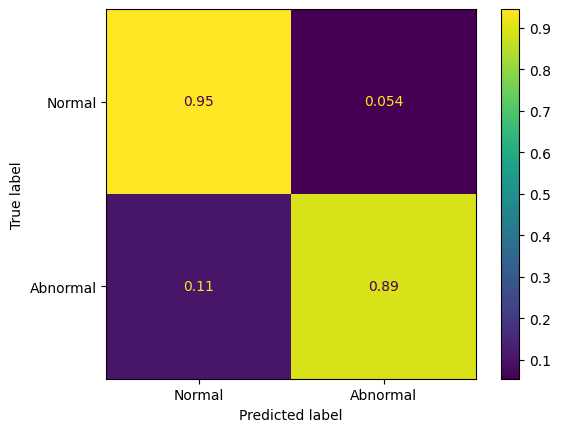

In [6]:
#Voting Classifier
Y_pred = CustomPipeline([('sample_extractor', SampleExtractor(num_samples=5000)), ('vote_clf', vote_clf)]).fit(X_train, Y_train).predict(X_test)

#Evaluation
evaluate_bin(Y_test, Y_pred)

smote with 5 class

In [27]:
# Binary Classifiers

models2 = {'SVC': CustomPipeline([('sample_extractor', SampleExtractor(num_samples=1000)), ('svc', svc)]),
          'KNN':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=20000)), ('knn', knn)]),
          'Random Forest':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=20000)), ('rf', rf)]),
          'Voting Ensemble':CustomPipeline([('sample_extractor', SampleExtractor(num_samples=10000)), ('vote_clf', vote_clf)])
          }
clf_results = pd.DataFrame()
clf_results_pca = pd.DataFrame()

for model_name, model in models2.items(): 
    clf_results = pd.concat([clf_results, train_and_eval(model, X_train, Y_train)], axis=0, ignore_index=True)
    clf_results_pca = pd.concat([clf_results_pca, train_and_eval(model, X_train, Y_train, True)], axis=0, ignore_index=True)

#LOF training and testing
Dataset_norm = pd.read_pickle("../Data/Data_te_norm.pkl")
Dataset_norm, Target_label_norm = SMOTEENN(random_state= 22).fit_resample(Dataset_norm, Attack_label)
norm_X_train, norm_X_test, norm_Y_train, norm_Y_test = train_test_split(Dataset, Target_label, train_size=25000, test_size=120000, random_state=22)
train_x = norm_X_train[norm_Y_train == 0]
test_Y = (((norm_Y_test*2)-1)*-1) #Converting the labels to -1 and 1
pred = lof.fit(train_x).predict(norm_X_test)

clf_results = pd.concat([clf_results, pd.DataFrame({'Average Accuracy Score': metrics.accuracy_score(test_Y, pred)*100,                              
                              'Precision':metrics.precision_score(test_Y, pred, pos_label= -1, average = 'binary')*100,
                              'Recall': metrics.recall_score(test_Y, pred, pos_label= -1, average = 'binary')*100,
                              'F1-Score': metrics.f1_score(test_Y, pred, pos_label= -1, average = 'binary' )*100},
                              index= ['LOF'])], axis=0, ignore_index=True)

clf_results.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble', 'LOF']] ,names=['Model'])
clf_results_pca.index = pd.MultiIndex.from_product([['SVC', 'KNN', 'Random Forest', 'Voting Ensemble']] ,names=['Model after PCA'])
print(clf_results)
print(clf_results_pca)

                 Average Accuracy Score  Precision     Recall   F1-Score
Model                                                                   
SVC                           87.473906  79.941092  99.884931  88.807063
KNN                           93.233580  88.459976  99.361168  93.594218
Random Forest                 98.403024  97.236665  99.621066  98.414425
Voting Ensemble               90.576560  84.124850  99.912706  91.341589
LOF                           85.165833  99.391893  83.268279  90.618462
                 Average Accuracy Score  Precision     Recall   F1-Score
Model after PCA                                                         
SVC                           95.405833  94.981498  99.940918  97.398117
KNN                           96.889167  97.508880  98.911349  98.205107
Random Forest                 96.885000  97.565079  98.846456  98.201588
Voting Ensemble               96.225000  95.976899  99.795636  97.849023


,Average Accuracy Score,Precision,Recall,F1-Score
Anomaly,92.436573,86.82739,99.962305,92.933028


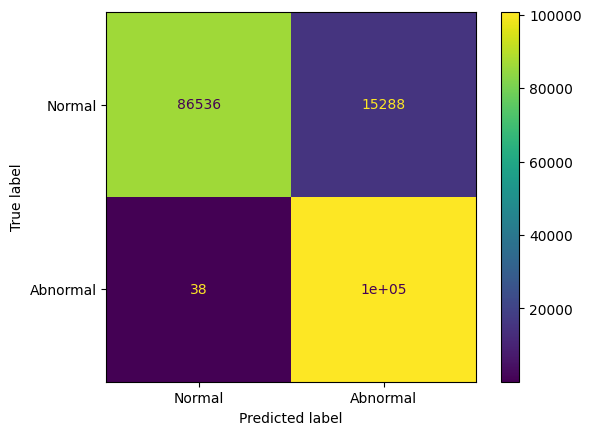

In [28]:
#Voting Classifier
Y_pred = CustomPipeline([('sample_extractor', SampleExtractor(num_samples=20000)), ('vote_clf', vote_clf)]).fit(X_train, Y_train).predict(X_bal_test)

#Evaluation
evaluate_bin(Y_bal_test, Y_pred)

## Novel Attack Tests

In [7]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]

model_results = pd.DataFrame()
for model_name, model in models.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval(model, x, y)], axis=0, ignore_index=True)
    model_results = pd.concat([model_results, result], axis=0)
    
model_results.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5']],
                                                 names=['Model', 'Novel Type'])

model_results

Average Accuracy Score  Precision     Recall  \
Model           Novel Type                                                   
SVC             novel type 1               81.090833  90.106493  69.887262   
                novel type 2               80.760000  91.753835  67.630847   
                novel type 3               80.940000  89.340359  70.300245   
                novel type 4               80.279167  97.793306  61.990641   
                novel type 5               80.910833  90.983317  68.658307   
KNN             novel type 1               84.034167  89.381332  77.275982   
                novel type 2               84.555000  88.456622  79.512414   
                novel type 3               84.598333  88.094060  80.040299   
                novel type 4               84.285000  93.984240  73.287705   
                novel type 5               82.015833  91.321160  70.789829   
Random Forest   novel type 1               90.181667  95.575489  84.281694   
                novel type 2               93.114167  95.559153  90.443123   
                novel type 3               95.743333  95.736286  95.758605   
                novel type 4               94.734167  97.202895  92.128358   
                novel type 5               95.609167  96.245146  94.929310   
Voting Ensemble novel type 1               91.293333  97.150244  85.097667   
                novel type 2               91.543333  94.703933  88.023513   
                novel type 3               91.935833  94.430920  89.142562   
                novel type 4               86.974167  96.991368  76.338446   
                novel type 5               86.446667  94.997431  76.969576   

                               F1-Score  
Model           Novel Type               
SVC             novel type 1  78.719274  
                novel type 2  77.866825  
                novel type 3  78.684858  
                novel type 4  75.880836  
                novel type 5  78.259797  
KNN             novel type 1  82.889014  
                novel type 2  83.746383  
                novel type 3  83.874289  
                novel type 4  82.355583  
                novel type 5  79.755349  
Random Forest   novel type 1  89.574005  
                novel type 2  92.930779  
                novel type 3  95.747444  
                novel type 4  94.597622  
                novel type 5  95.582700  
Voting Ensemble novel type 1  90.725420  
                novel type 2  91.241607  
                novel type 3  91.710568  
                novel type 4  85.434469  
                novel type 5  85.038544

smote 5 class

In [29]:
#Training set without the novel attack types
X_train_nov1 = remove_attack_type(np.array(X_train), 1)
Y_train_nov1 = remove_attack_type(np.array(Y_train), 1)
X_train_nov2 = remove_attack_type(np.array(X_train), 2)
Y_train_nov2 = remove_attack_type(np.array(Y_train), 2)
X_train_nov3 = remove_attack_type(np.array(X_train), 3)
Y_train_nov3 = remove_attack_type(np.array(Y_train), 3)
X_train_nov4 = remove_attack_type(np.array(X_train), 4)
Y_train_nov4 = remove_attack_type(np.array(Y_train), 4)
X_train_nov5 = remove_attack_type(np.array(X_train), 5)
Y_train_nov5 = remove_attack_type(np.array(Y_train), 5)

trainings = [(X_train_nov1, Y_train_nov1), (X_train_nov2, Y_train_nov2), (X_train_nov3, Y_train_nov3),
             (X_train_nov4, Y_train_nov4), (X_train_nov5, Y_train_nov5)]


model_results = pd.DataFrame()
for model_name, model in models2.items(): 
    result = pd.DataFrame()
    for i, (x, y) in enumerate(trainings):
        result = pd.concat([result, train_and_eval(model, x, y)], axis=0, ignore_index=True)
    model_results = pd.concat([model_results, result], axis=0)
    
model_results.index = pd.MultiIndex.from_product([models.keys(), ['novel type 1', 'novel type 2', 'novel type 3', 'novel type 4', 'novel type 5']],
                                                 names=['Model', 'Novel Type'])

model_results


Average Accuracy Score  Precision     Recall  \
Model           Novel Type                                                   
SVC             novel type 1               87.692528  80.360630  99.603210   
                novel type 2               87.758657  80.446905  99.603210   
                novel type 3               84.279461  80.177862  90.864903   
                novel type 4               87.973825  81.575295  97.949588   
                novel type 5               90.564222  89.869686  91.328155   
KNN             novel type 1               93.695992  89.400897  99.074487   
                novel type 2               93.847498  89.446846  99.355216   
                novel type 3               93.886484  89.509290  99.356208   
                novel type 4               95.904912  95.587641  96.209664   
                novel type 5               93.244437  90.629022  96.387227   
Random Forest   novel type 1               94.377026  97.367166  91.162495   
                novel type 2               98.594503  97.639449  99.582379   
                novel type 3               98.612269  97.645835  99.612138   
                novel type 4               99.242473  99.561666  98.912795   
                novel type 5               94.626739  97.454219  91.592021   
Voting Ensemble novel type 1               90.841571  84.485925  99.943457   
                novel type 2               90.907700  84.567616  99.966273   
                novel type 3               91.159387  84.950543  99.933538   
                novel type 4               95.152813  92.989369  97.616284   
                novel type 5               91.506319  86.064089  98.949499   

                               F1-Score  
Model           Novel Type               
SVC             novel type 1  88.953166  
                novel type 2  89.005997  
                novel type 3  85.187510  
                novel type 4  89.015700  
                novel type 5  90.593051  
KNN             novel type 1  93.989441  
                novel type 2  94.141034  
                novel type 3  94.176054  
                novel type 4  95.897644  
                novel type 5  93.419478  
Random Forest   novel type 1  94.162730  
                novel type 2  98.601344  
                novel type 3  98.619186  
                novel type 4  99.236170  
                novel type 5  94.432228  
Voting Ensemble novel type 1  91.566922  
                novel type 2  91.624465  
                novel type 3  91.834930  
                novel type 4  95.246668  
                novel type 5  92.058087

<Axes: title={'center': 'F1-Score of Models on Novel Attack Types'}, xlabel='Model'>

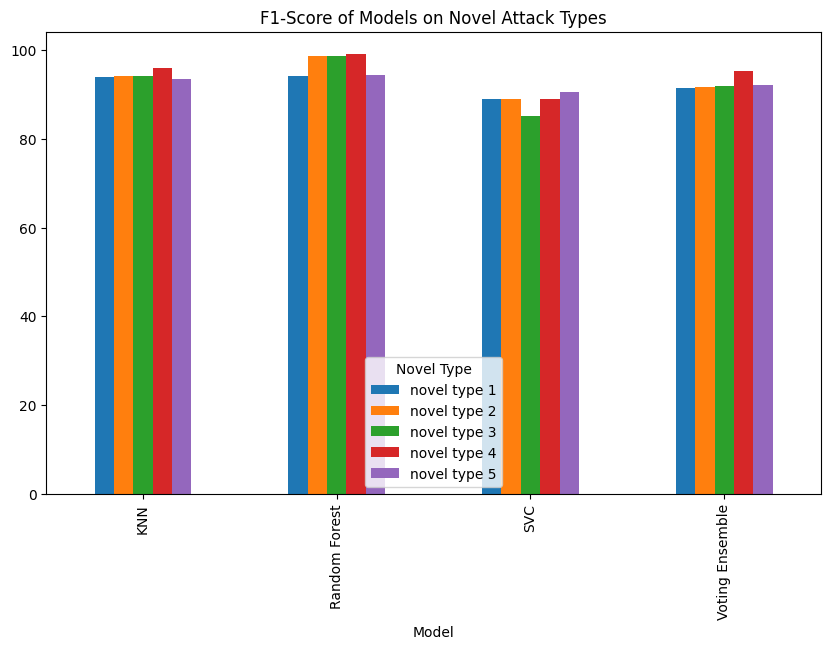

In [30]:
model_results['F1-Score'].unstack().plot(kind='bar', figsize=(10, 6), title='F1-Score of Models on Novel Attack Types')